In [21]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from deap import base, creator, tools, algorithms
from optimize_portfolio import optimize_portfolio


In [31]:
"""
Data Setup
"""

# Load the dataset
asset_index = pd.read_excel("data/asset_index.xlsx")
trade_dt = pd.read_excel("data/ashare_trading_calender.xlsx")
asset_index = asset_index[asset_index['TRADE_DT'].isin(trade_dt['TRADE_DT'])]

unique_assets = asset_index['INDEX_CODE'].unique() # index_code list
print(unique_assets)

['HSI.HI' 'DOLLAR' 'GC.CMX' 'h00300.CSI' 'CBA02001.CS']


In [23]:
"""
Clustering (Optional)
"""


'\nClustering (Optional)\n'

In [24]:
"""
GA Initialization
"""

# Objective Setup
creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0, -1.0)) # MAX: return, sharpe; MIN: volatility (Equally-weighed)
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Individual Initialization (Clustering?)
def create_individual():
    individual = [random.randint(0, 1) for _ in range(len(unique_assets))]
    if sum(individual) == 0:  # If all zeros, randomly set one to 1
        individual[random.randint(0, len(unique_assets) - 1)] = 1
    return individual

# GA Initialization
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(unique_assets))
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [25]:
"""
Fitness Function with Regularization (Optional, prevent overfitting)
"""

# Fitness Function
def evaluate(individual):
    # Select assets based on the individual's binary vector
    selected_assets = [asset for asset, include in zip(unique_assets, individual) if include]

    # if selected assets are empty (might be caused by mutation, crossover), just set output to extreme situation?
    if len(selected_assets) == 0:
        return 0, 0, 99999 # min return/sharpe, max volatility

    # Model output (new weights)
    new_weights, evaluation = optimize_portfolio('RP', selected_assets, asset_index)

    # Expected Return, Sharpe Ratio, Volatility (Add regularization parameters? a+b+c=1?)
    expected_return, sharpe_ratio, volatility = evaluation

    return expected_return, sharpe_ratio, volatility

In [26]:
"""
Genetic Algorithm Setup
"""

# NSGA-II
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selNSGA2)

In [27]:
"""
Stopping Criteria (Optional)
"""

# Method 1 - Stable Pareto Front
def is_pareto_stable(history, gen, stability_threshold=10):
    if gen < stability_threshold:
        return False
    last_fronts = history[-stability_threshold:]
    return all(last_fronts[-1] == front for front in last_fronts)

# Method 2 - Stable Pareto Front Size
def is_pareto_size_stable(history, stability_threshold=50, relative_range=0.05):
    if len(history) < stability_threshold:
        return False

    sizes = [len(front) for front in history[-stability_threshold:]]
    max_size = max(sizes)
    min_size = min(sizes)

    if max_size == 0:
        return False

    size_fluctuation = (max_size - min_size) / max_size
    return size_fluctuation <= relative_range

# Method 3 - No Significant Improvements
def no_significant_improvements(history, gen, stability_threshold=50, improvement_threshold=0.01):
    if gen < stability_threshold:
        return False
    recent_hvs = history[-stability_threshold:]
    return all((hv - min(recent_hvs)) / hv < improvement_threshold for hv in recent_hvs)

In [28]:
from deap.algorithms import varAnd

""""
Run Genetic Algorithm
"""

# Running the GA
def run_ga(pop_size, num_generations):
    pop = toolbox.population(n=pop_size)
    hof = tools.ParetoFront()
    logbook = tools.Logbook()
    stats = tools.Statistics(lambda ind: ind.fitness.values)

    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    # refactor eaSimple for stopping criteria
    def eaSimpleMod(cxpb, mutpb):
        logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

        hv_history = [] # hv record
        pareto_history = [] # pareto record

        for gen in range(num_generations):
            offspring = toolbox.select(pop, len(pop))

            offspring = varAnd(offspring, toolbox, cxpb, mutpb)

            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit

            if hof is not None:
                hof.update(offspring)
                pareto_history.append(list(hof))

            pop[:] = offspring

            record = stats.compile(pop) if stats else {}
            logbook.record(gen=gen, nevals=len(invalid_ind), **record)
            print(logbook.stream)

            # Calculate hypervolume
            modified_front = []
            for ind in hof:
                modified_ind = toolbox.clone(ind)
                modified_values = [ind.fitness.values[0], ind.fitness.values[1], -ind.fitness.values[2]]
                modified_ind.fitness.values = tuple(modified_values)
                modified_front.append(modified_ind)
            hv = tools.hypervolume(modified_front)
            hv_history.append(hv)

            # Stopping Criteria
            if no_significant_improvements(hv_history, gen) and is_pareto_size_stable(pareto_history):
                print(f"Stopping GA at generation {gen}")
                break

    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=num_generations, stats=stats, halloffame=hof, verbose=True)
    # eaSimpleMod(0.7, 0.2)

    return pop, hof, stats, logbook

# Example run
population, pareto_front, stats, logbook = run_ga(500, 1000)  # X individuals, Y generations

gen	nevals	avg                                           	std                                           	min                                              	max                                           
0  	500   	[5.69916563e-02 1.23227441e-03 3.36942661e+02]	[3.59914191e-02 2.59829517e-03 5.70333795e+02]	[ 1.70346625e-02 -4.06500482e-05  2.82493371e-01]	[2.01615258e-01 1.30292262e-02 2.34944731e+03]
1  	360   	[5.71415776e-02 1.23339354e-03 7.46185302e+02]	[3.63705061e-02 2.60585020e-03 6.31593790e+03]	[ 0.00000000e+00 -4.06500482e-05  2.82493371e-01]	[2.01615258e-01 1.30292262e-02 9.99990000e+04]
2  	363   	[5.79344554e-02 1.18661123e-03 7.47502483e+02]	[3.73617108e-02 2.45915748e-03 6.31581160e+03]	[ 0.00000000e+00 -4.06500482e-05  2.82493371e-01]	[2.01615258e-01 1.30292262e-02 9.99990000e+04]
3  	392   	[5.76231626e-02 1.14441529e-03 7.42899510e+02]	[3.72825148e-02 2.39329912e-03 6.31576358e+03]	[ 0.00000000e+00 -4.06500482e-05  2.82493371e-01]	[2.01615258e-01 1.30292262e-02 9.9999

In [29]:
"""
Pareto Front
"""

# Retrieve Weights/evaluations
def get_weights_evaluations(individual):
    selected_assets = [asset for asset, include in zip(unique_assets, individual) if include]
    new_weights, evaluation = optimize_portfolio('MVO', selected_assets, asset_index)
    return new_weights, evaluation

# Retrieve and store weights/evaluations
individual_weights = {str(ind): get_weights_evaluations(ind)[0] for ind in pareto_front}
individual_evaluations = {str(ind): get_weights_evaluations(ind)[1] for ind in pareto_front}

# Output
for i, ind in enumerate(pareto_front):
    print(f"Pareto Front {i}")
    print(f"Individual: {ind}")
    print(f"Weights: {individual_weights[str(ind)]}")
    print(f"Evaluations: {individual_evaluations[str(ind)]}")
    print("")

Pareto Front 0
Individual: [0, 0, 0, 1, 0]
Weights: [0.99999998]
Evaluations: (0.20161525394704422, 0.0003007626459446082, 603.8491029251436)

Pareto Front 1
Individual: [0, 0, 1, 1, 0]
Weights: [0.00875096 0.99124904]
Evaluations: (0.19999999999999998, 0.00030075507775434896, 598.4936358980465)

Pareto Front 2
Individual: [0, 0, 0, 1, 1]
Weights: [0.98849455 0.01150545]
Evaluations: (0.19999999999999998, 0.0003015554657264116, 596.9051151714368)

Pareto Front 3
Individual: [0, 0, 1, 1, 1]
Weights: [-2.26436397e-23  9.88494552e-01  1.15054476e-02]
Evaluations: (0.19999999999999998, 0.0003015554657264116, 596.9051151714368)

Pareto Front 4
Individual: [0, 0, 0, 0, 1]
Weights: [1.0]
Evaluations: (0.061224517487699526, 0.005200134912351361, 7.927586145848457)

Pareto Front 5
Individual: [0, 1, 0, 0, 1]
Weights: [0.5, 0.5]
Evaluations: (0.04245259375677812, 0.005489715105155573, 4.089937879598187)

Pareto Front 6
Individual: [0, 1, 0, 0, 0]
Weights: [1.0]
Evaluations: (0.02368067002585672,

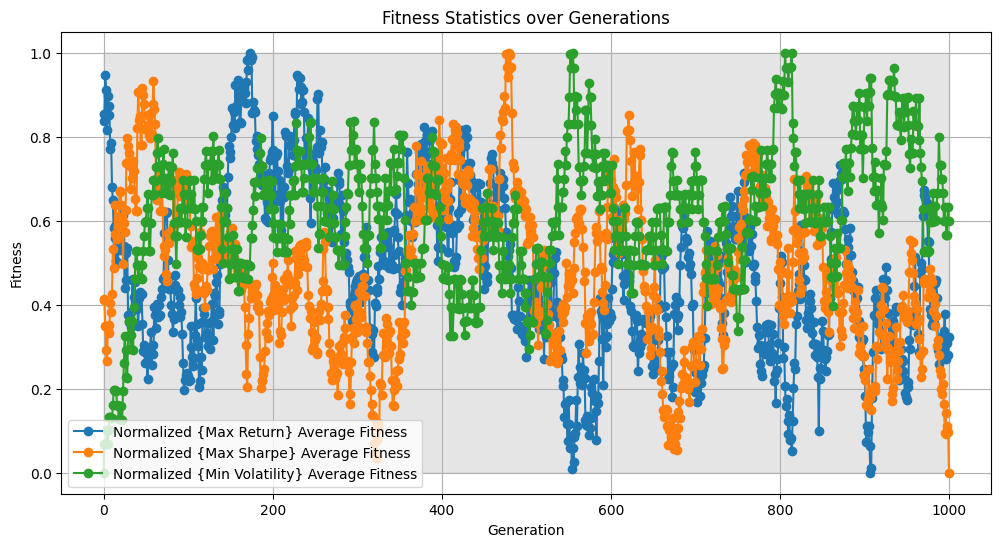

In [30]:
"""
Visualization
"""

# Extracting the statistics
gen = logbook.select("gen")
avg_fitness = logbook.select("avg")
std_fitness = logbook.select("std")
min_fitness = logbook.select("min")
max_fitness = logbook.select("max")

# Normalization function
def normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

# Normalizing the average fitness for each objective
normalized_avg_fitness = [normalize([fit[i] for fit in avg_fitness]) for i in range(len(avg_fitness[0]))]

# Plotting for multiple objectives
plt.figure(figsize=(12, 6))

# Each objective (Avg)
plt.plot(gen, normalized_avg_fitness[0], label=f'Normalized {{Max Return}} Average Fitness', marker='o')
plt.plot(gen, normalized_avg_fitness[1], label=f'Normalized {{Max Sharpe}} Average Fitness', marker='o')
plt.plot(gen, normalized_avg_fitness[2], label=f'Normalized {{Min Volatility}} Average Fitness', marker='o')

# Misc
plt.fill_between(gen, 0, 1, alpha=0.2, color='grey')
plt.title('Fitness Statistics over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)
plt.show()
